# Plotting the BH mass distribution for several SFRD Z-distribution variations



In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats

import h5py
from astropy.table import vstack, Table, Column
import astropy.units as u
from astropy import constants as const

# Chosen cosmology 
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

import json
import argparse

# My own helper funcitons:
import importlib
import MassDistHelperFunctions as mfunc
importlib.reload(mfunc)

import gc

#########################################
# Nice little progressbar script 
# to know how far you are with bootstrapping
#########################################
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()


######################################
## locations
save_loc    =  '/Users/lieke/surfdrive/Documents'+'/SFRD_fit/src/tex/figures/' #/n/home04/lvanson/
data_dir    = '/Volumes/StorageSpac'+'/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output/' # '/n/holystore01/LABS/hernquist_lab/Users/lvanson/'


######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))



# Mass dist split by redshift

In [9]:
# Distribution plot function
def plot_mass_distribution(sim_dir = '', x_key = 'M_moreMassive', rate_keys = ['Rates_mu00.025_muz-0.05_alpha-1.77_sigma0%s_sigmaz0.05_zBinned'%(x) for x in [0.8, 1.125, 1.4]],
                           bins = np.arange(0.,55,2.5), z_bin_edges = [0,0.5], 
                           plot_LIGO = False, show_hist = False, show_KDE = True, kde_width = 0.1,  
                           bootstrap = False, bootstraps = 10, x_lim=(0.,50),  y_lim = (1e-2,50), 
                           colors = ['#488496', '#73bdb3', '#e388b0'], linestyles = ['--','-', ':'], 
                           labels = ['$\mathrm{CE \ channel = \ }$', '$\mathrm{stable \ RLOF \ channel = \ }$', '$\mathrm{All = \ }$'],
                           xlabel = r'$M_{\mathrm{BH, 1}} \ \rm [M_{\odot}]$', ylabel = r'$\frac{d\mathcal{R}}{dM_{BH, 1}} \ \mathrm{[Gpc^{-3}yr^{-1}M^{-1}_{\odot}]}$',
                           leg_args = {'loc':'upper right', 'fontsize':'20', 'title':''},leg1_args = {'loc':'upper left', 'fontsize':18},
                           save_plot=False, save_name = 'Fiducial.png', multipanel = False, subplot = None):
    """
        Read DCO, SYS and merger rate data, necesarry to make the plots in this 
        
        Args:
            sim_dir              --> [string] Location of data

        Returns:
         plot

    """
   
    #########################################
    mass_binw = np.diff(bins)[0]

    plot_lines = []
    leg_labels = []

    #########################################
    # Start plotting
    if not multipanel: #(otherwise you define the Fig outside of this fucntion)
        fig, ax = plt.subplots(figsize = (12, 10))
    else:
        ax = subplot
    
    ################################################
    # GWTC-3 Powerlaw + Peak Mass distribution
    ################################################ 
    if plot_LIGO:
        LIGO_data_dir = '/Volumes/StorageSpac/CompasOutput//output/'#'/n/home04/lvanson/LowMBH_peak/output/'
        ##############################
        # Load LIGO Utils
#         sys.path.insert(0,LIGO_data_dir+'utils/')
        #################################################
        ## prep to grab Powerlaw + Peak data from O3
        #################################################
        input_fname = LIGO_data_dir+'/GWTC-3-population-data/analyses/PowerLawPeak/o3only_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'
        output_fname = './plots'
        cli_parser = argparse.ArgumentParser()
        cli_parser.add_argument("input_fname")
        cli_parser.add_argument("output_fname")
        cli_args = cli_parser.parse_args( (input_fname + ' ' + output_fname).split() )
        O3_only_PPD = cli_args.input_fname
        O3_only_result = O3_only_PPD.replace("_mass_data.h5", "_result.json")

        with open(O3_only_result, "r") as jfile:
            plpeak_jf = json.load(jfile)

        ##############################
        # Calculate relevant values
        mass_1 = np.linspace(2, 100, 1000)
        mass_ratio = np.linspace(0.1, 1, 500)
        color_plpeak = 'grey'#'#1f78b4'
        
        with h5py.File(O3_only_PPD, "r") as f:
            mass_ppd = f["ppd"]
            mass_lines = f["lines"]
            mass_1_ppd = np.trapz(mass_ppd, mass_ratio, axis=0)
            mass_1_lower = np.percentile(mass_lines["mass_1"], 5, axis=0)
            mass_1_upper = np.percentile(mass_lines["mass_1"], 95, axis=0)

        ##############################
        # plot the max posterior and the 95th percentile
        ax.plot(mass_1, mass_1_ppd, lw=1.8, color=color_plpeak, zorder=1, label="$\mathrm{GWTC-3}$")
        ax.fill_between(mass_1, mass_1_lower, mass_1_upper, alpha=0.14,color=color_plpeak,zorder=0)

        legend1 = plt.legend(**leg1_args)

    nplot = 0
    
    ################################################
    # My Simulations
    ################################################
    DCO = mfunc.read_data(loc = sim_dir +'/COMPAS_Output_wWeights.h5')

    
    print('nplot', nplot, '\n')
    ####################################################
    ### Loop over SFRD
    for i, rate_key in enumerate(rate_keys):
        print('rate_key', rate_key)
        ### ## Reading Rate data ##
        try:
            DCO_mask, redshifts, intrinsic_rate_density, intrinsic_rate_density_z0  = mfunc.read_rate_data(loc = sim_dir + '/Rate_info.hdf5', rate_key = rate_key)
        except:
            print('\n error reading', rate_key)
            continue
        
        # # # # # # # # # # # # # # # # # # 
        #first bring it to the same shape as the rate table
        merging_BBH    = DCO[DCO_mask]
        #then apply the additional mask based on your prefs
        merging_BBH         = merging_BBH[(merging_BBH['Stellar_Type@ZAMS(1)'] != 16)]
        Red_intr_rate_dens  = intrinsic_rate_density[(DCO['Stellar_Type@ZAMS(1)'][DCO_mask] != 16), :]

        # # # # # # # # # # # # # # # # # # 
        ## Calculate average rate density per z-bin
        crude_rate_density = mfunc.get_crude_rate_density(Red_intr_rate_dens[:,:], redshifts, z_bin_edges)
        #########################################
        # X value and weight
        x_vals                = merging_BBH[x_key]
        Weights = crude_rate_density[:,0]

        print(labels[i], ' len(table)=', len(merging_BBH) , ' Rate = ', np.sum(Weights), ' Gpc-3 yr-1')

        ########################
        # Get the Hist    
        hist, bin_edge = np.histogram(x_vals, weights = Weights, bins=bins)
        y_vals = hist/mass_binw

        center_bins = (bin_edge[:-1] + bin_edge[1:])/2.

        # And the KDE
        kernel = stats.gaussian_kde(x_vals, bw_method=kde_width, weights=Weights)
        binwidth = np.diff(bin_edge)

        ########################
        # Plot the Hist 
        if show_hist:
            plot_lines.append(ax.step(center_bins, y_vals,  where='mid',label = None,#labels[i]+'$%s \mathrm{ \ Gpc^{-3} yr^{-1}}$'%(np.round(np.sum(Weights),1)) , 
                                      alpha=1.0, lw = 3.5, zorder = i, color= colors[nplot], 
                                      marker = 'o', markersize = 15) ) #edgecolor=colors[i],
            # to prevent overflowing
            min_xkde = min(center_bins[y_vals>5e-4])

        ########################
        # Add KDE
        if show_KDE:
            min_xkde    = 0.1
            x_KDE = np.arange(min_xkde,50.,0.1)
            KDEy_vals =  kernel(x_KDE)*sum(hist) #re-normalize the KDE
            leg_labels.append(labels[nplot]+'$%s$'%(np.round(np.sum(Weights),1)))
    
            print(nplot, len(colors), len(linestyles))
            if not show_hist:
                plot_lines.append(ax.plot(x_KDE, KDEy_vals, label = '', color=colors[nplot], lw= 5,  zorder =i+1,ls = linestyles[nplot]))

            ########################
            # Bootstrap   
            if bootstrap:
                indices = np.arange(len(x_vals))
                hist_vals = np.zeros((bootstraps, len(x_KDE)))  #center_bins
                for b in progressbar( range(len(hist_vals)), "Bootstrapping "+ labels[i] + ":"):
                    boot_index = np.random.choice(indices, size=len(indices), replace=True)
                    kernel         = stats.gaussian_kde(x_vals[boot_index], bw_method=kde_width, weights=Weights[boot_index])
                    Hist, _        = np.histogram(x_vals[boot_index], bins=bins, weights=Weights[boot_index],density=False)
                    hist_vals[b]   = kernel(x_KDE)*sum(Hist)

                # calculate 1- and 2- sigma percentiles
                y_vals = hist_vals#/mass_binw

                percentiles = np.percentile(y_vals, [10., 90.], axis=0)
                print('nplot',nplot, 'np.shape(percentiles)', np.shape(percentiles))
                ax.fill_between(x_KDE, percentiles[0],percentiles[1], alpha=0.4, color=colors[nplot], zorder = 11) # 1-sigma

#             leg_labels.append(labels[nplot]+'$%s$'%(np.round(0.0,1)))

#             plot_lines.append(ax.plot(np.arange(0,1,0.1),np.arange(0,1,0.1)) )

            nplot += 1

    #########################################
    # plot values
    ax.grid(True, dashes=(1, 3))
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    #####
    # add legend for simulations
    leg = ax.legend(**leg_args)
    leg = plt.legend([l[0] for l in plot_lines], [l for l in leg_labels ],  **leg_args)
    leg.set_zorder(102)
    leg._legend_box.align = "right"

    # Legend for GWTC-3
    if plot_LIGO:
        plt.gca().add_artist(legend1)

    s = ['$[%s \leq z < %s]$'%(z_bin_edges[a],z_bin_edges[a+1]) for a in range(0,len(z_bin_edges)-1)]   
    
    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)

    ax.set_yscale('log')
      
    if not multipanel:
        if save_plot:
            plt.savefig(save_loc+'/'+save_name , bbox_inches='tight')

        plt.show()
        # clear memory
        gc.collect()
    else:
        return ax



    

nplot 0 

rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma00.8_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5

 error reading Rates_mu00.025_muz-0.05_alpha-1.77_sigma00.8_sigmaz0.05_zBinned
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Fiducial: \ } (\sigma_0 = 1.125) \ \mathcal{R}_{0}= \ $  len(table)= 2252487  Rate =  109.33972509651458  Gpc-3 yr-1
0 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.4_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Wide \ SFRD: \ } \phantom{xx} (\sigma_0 = 1.

No handles with labels found to put in legend.


1 3 3
nplot 0 

rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.025_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Flat \ width: \ } \phantom{i} (\sigma_z = 0.025) \ \mathcal{R}_{0} = \ $  len(table)= 2252487  Rate =  92.23054132419672  Gpc-3 yr-1
0 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Fiducial: \ } \phantom{xxi} (\sigma_z = 0.050) \ \mathcal{R}_{0}= \ $  len(table)= 2252487  Rate =  109.33972509651458  Gpc-3 yr-1
1 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.1_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fW

No handles with labels found to put in legend.


2 3 3
nplot 0 

rate_key Rates_mu00.015_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{low \ <Z_0> : \ } \phantom{i} (\mu_0 = 0.015) \ \mathcal{R}_{0} = \ $  len(table)= 2252487  Rate =  206.80315998502934  Gpc-3 yr-1
0 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Fiducial: \ } (\mu_0 = 0.025) \ \mathcal{R}_{0} = \ $  len(table)= 2252487  Rate =  109.33972509651458  Gpc-3 yr-1
1 3 3
rate_key Rates_mu00.035_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/ou

No handles with labels found to put in legend.


2 3 3
nplot 0 

rate_key Rates_mu00.025_muz-0.01_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Flat: \ } \phantom{xx} (\mu_z = -0.01) \ \mathcal{R}_{0} = \ $  len(table)= 2252487  Rate =  93.64520783624933  Gpc-3 yr-1
0 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Fiducial: \ } (\mu_z = -0.05) \ \mathcal{R}_{0}= \ $  len(table)= 2252487  Rate =  109.33972509651458  Gpc-3 yr-1
1 3 3
rate_key Rates_mu00.025_muz-0.25_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rat

No handles with labels found to put in legend.


2 3 3
nplot 0 

rate_key Rates_mu00.025_muz-0.05_alpha-0.9_sigma01.125_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Symmetric: \ } $$(\alpha = -0.9) $$ \ \mathcal{R}_{0} = \ $  len(table)= 2252487  Rate =  165.86561777165582  Gpc-3 yr-1
0 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Fiducial: \ } $$(\alpha = -1.77) $$\ \mathcal{R}_{0}= \ $  len(table)= 2252487  Rate =  109.33972509651458  Gpc-3 yr-1
1 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-3.5_sigma01.125_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Ra

No handles with labels found to put in legend.


2 3 3
nplot 0 

rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.01_b2.6_c3.2_d6.2_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Madau \ \& \ Fragos \ 2017: } \ \mathcal{R}_{0} = \ $  len(table)= 2252487  Rate =  93.18837274895172  Gpc-3 yr-1
0 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Fiducial: \ } \phantom{xxxxxxx} \ \mathcal{R}_{0}= \ $  len(table)= 2252487  Rate =  109.33972509651458  Gpc-3 yr-1
1 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.01_b2.77_c2.9_d4.7_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fi

No handles with labels found to put in legend.


2 3 3


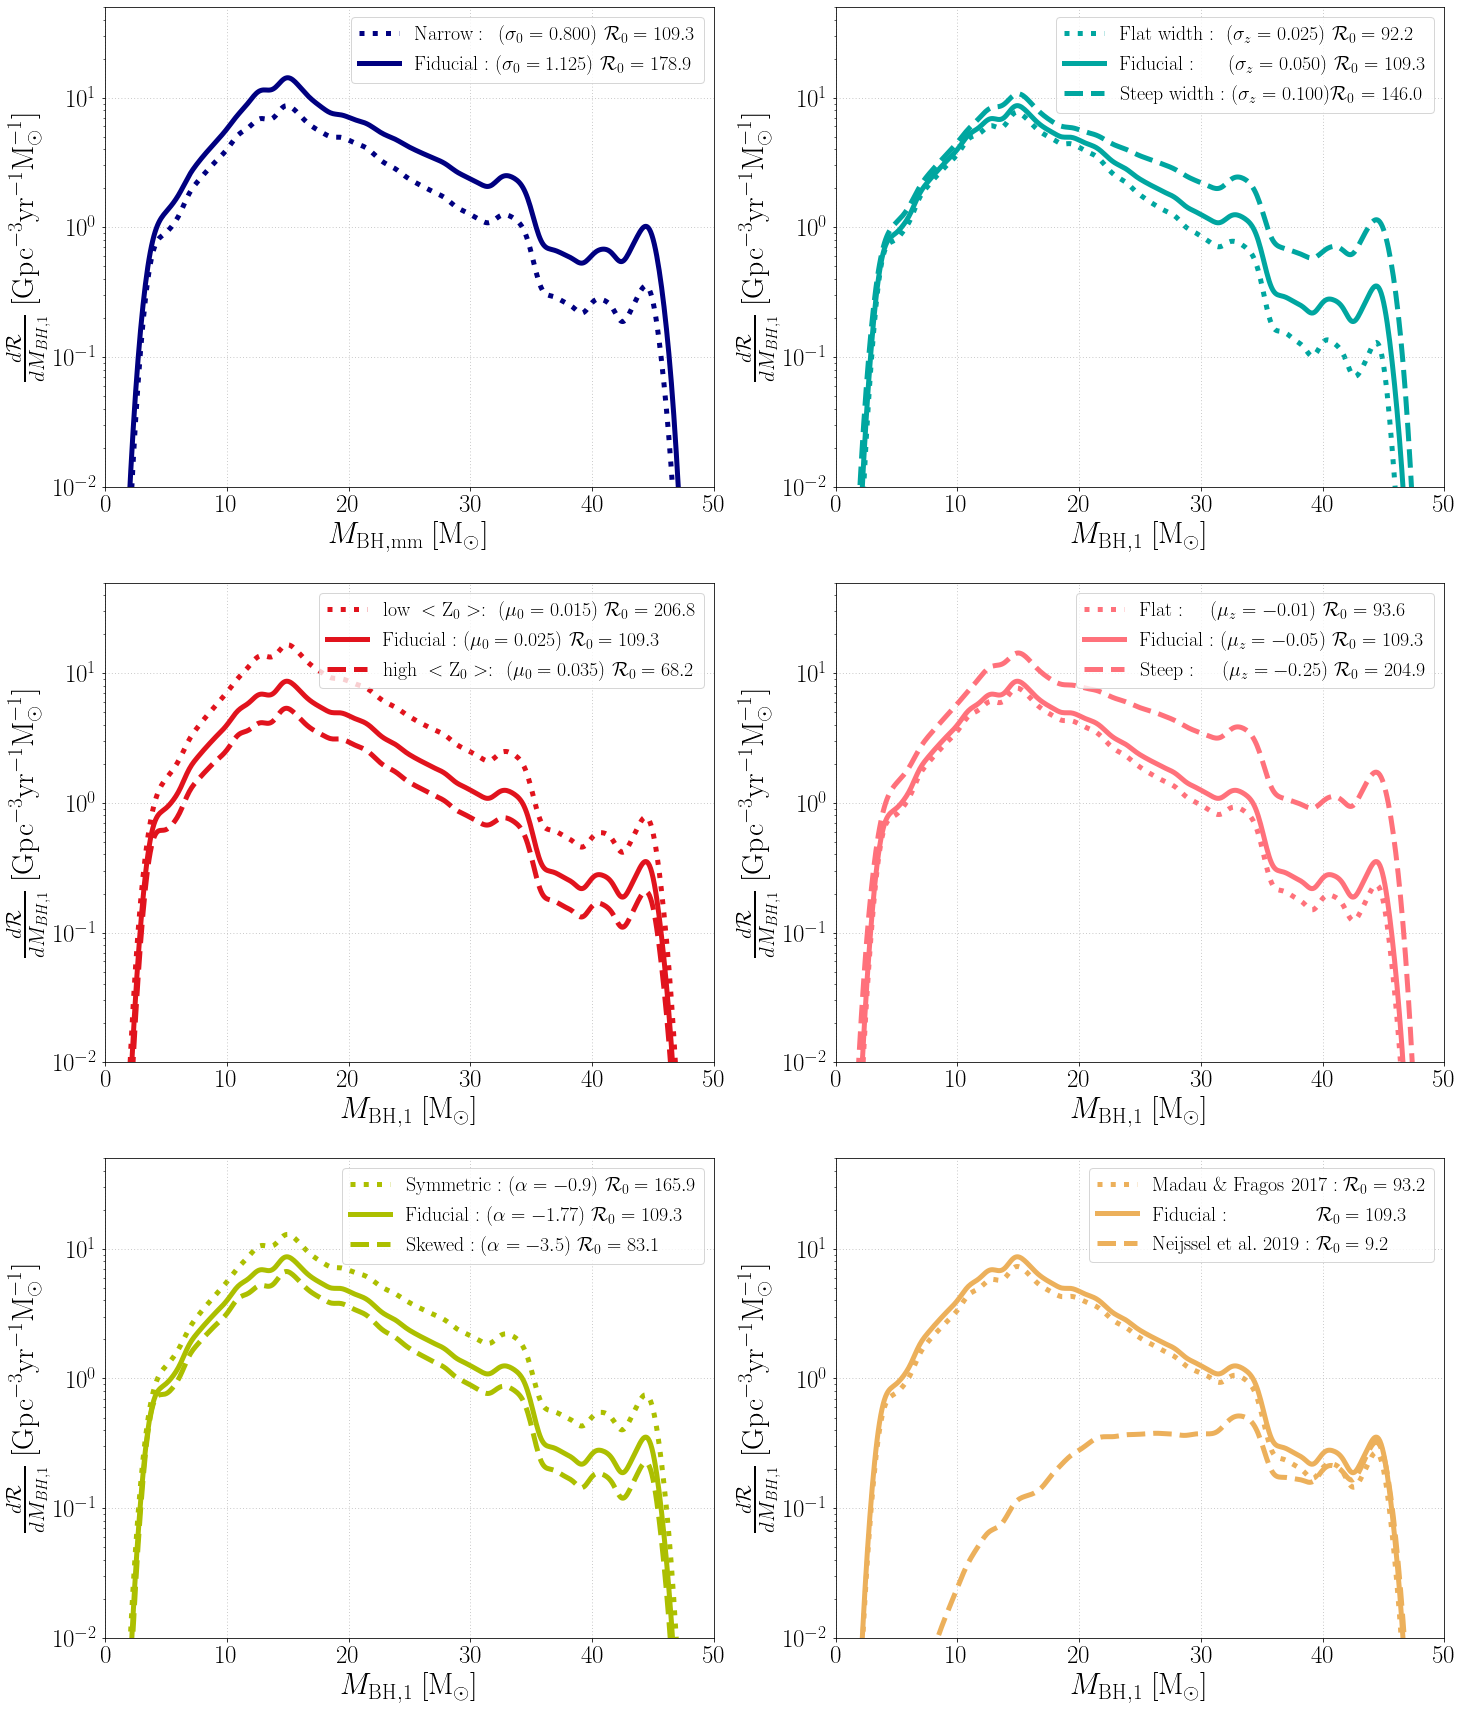

In [6]:

#define figure
fig = plt.figure( figsize = (24, 30))


####################################################
# width of SFRD at z=0
####################################################
#add first subplot in layout that has 3 rows and 2 columns
subplot1 = fig.add_subplot(321)

ax1 = plot_mass_distribution(sim_dir = data_dir, x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz-0.05_alpha-1.77_sigma0%s_sigmaz0.05_zBinned'%(x) for x in [0.8, 1.125, 1.4]],
                       show_hist = False, show_KDE = True, kde_width = 0.07, plot_LIGO = False, linestyles = [':','-', '--'], colors = ['navy',  'navy', 'navy'], 
                       bootstrap = False, bootstraps = 50, save_name = 'SFRD_width_variations.pdf', save_plot=False, 
                       xlabel = r'$M_{\mathrm{BH, mm}} \ \rm [M_{\odot}]$', 
                       labels = ['$\mathrm{Narrow: \ } \phantom{0} (\sigma_0 = 0.800) \  \mathcal{R}_{0} = \ $',
                                 '$\mathrm{Fiducial: \ } (\sigma_0 = 1.125) \ \mathcal{R}_{0}= \ $', 
                                 '$\mathrm{Wide \ SFRD: \ } \phantom{xx} (\sigma_0 = 1.400) \  \mathcal{R}_{0} = \ $'],
                      multipanel = True, subplot = subplot1)


####################################################
# Redshift evolution of the width
####################################################
#add Second subplot in layout that has 3 rows and 2 columns
subplot2 = fig.add_subplot(322)

ax2 = plot_mass_distribution(sim_dir = data_dir, x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz%s_zBinned'%(x) for x in [0.025, 0.05, 0.1]],
                       show_hist = False, show_KDE = True, kde_width = 0.07, plot_LIGO = False, linestyles = [':','-', '--'], colors = ['#00a6a0',  '#00a6a0', '#00a6a0'], 
                       bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_width_variations.pdf', save_plot=True, 
                       labels = ['$\mathrm{Flat \ width: \ } \phantom{i} (\sigma_z = 0.025) \ \mathcal{R}_{0} = \ $',
                                 '$\mathrm{Fiducial: \ } \phantom{xxi} (\sigma_z = 0.050) \ \mathcal{R}_{0}= \ $', 
                                 '$\mathrm{Steep \ width: \ } (\sigma_z = 0.100) \\mathcal{R}_{0} = \ $'],
                        multipanel = True, subplot = subplot2)


####################################################
# Mean metallicity at z=0
####################################################
#add third subplot in layout that has 3 rows and 2 columns
subplot3 = fig.add_subplot(323)

ax3 = plot_mass_distribution(sim_dir = data_dir, x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'%(x) for x in [0.015, 0.025, 0.035]],
                       show_hist = False, show_KDE = True, kde_width = 0.07, plot_LIGO = False, linestyles = [':','-', '--'], colors = ['#e1131d',  '#e1131d', '#e1131d'], 
                       bootstrap = False, bootstraps = 50, save_name = 'SFRD_meanZ_variations.pdf', save_plot=True, 
                       labels = ['$\mathrm{low \ <Z_0> : \ } \phantom{i} (\mu_0 = 0.015) \ \mathcal{R}_{0} = \ $',
                                 '$\mathrm{Fiducial: \ } (\mu_0 = 0.025) \ \mathcal{R}_{0} = \ $', 
                                 '$\mathrm{high \ <Z_0> : \ } \phantom{i} (\mu_0 = 0.035) \ \mathcal{R}_{0} = \ $'],
                        multipanel = True, subplot = subplot3)

####################################################
# Redshift evolution of mean metallicity
####################################################
#add 4th subplot in layout that has 3 rows and 2 columns
subplot4 = fig.add_subplot(324)

ax4 = plot_mass_distribution(sim_dir = data_dir, x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz%s_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'%(x) for x in [-0.01, -0.05, -0.25]],
                       show_hist = False, show_KDE = True, kde_width = 0.07, plot_LIGO = False, linestyles = [':','-', '--'], colors = ['#ff717b',  '#ff717b', '#ff717b'], 
                       bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_mean_variations.pdf', save_plot=True, 
                       labels = ['$\mathrm{Flat: \ } \phantom{xx} (\mu_z = -0.01) \ \mathcal{R}_{0} = \ $',
                                 '$\mathrm{Fiducial: \ } (\mu_z = -0.05) \ \mathcal{R}_{0}= \ $', 
                                 '$\mathrm{Steep: \ } \phantom{xx} (\mu_z = -0.25) \ \mathcal{R}_{0} = \ $'],
                        multipanel = True, subplot = subplot4)


####################################################
# Skewness
####################################################
#add 4th subplot in layout that has 3 rows and 2 columns
subplot5 = fig.add_subplot(325)

ax5 = plot_mass_distribution(sim_dir = data_dir, x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz-0.05_alpha%s_sigma01.125_sigmaz0.05_zBinned'%(x) for x in [-0.9, -1.77, -3.5]],
                       show_hist = False, show_KDE = True, kde_width = 0.07, plot_LIGO = False, linestyles = [':','-', '--'], colors = ['#acbf00',  '#acbf00', '#acbf00'], 
                       bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', save_plot=True, 
                       labels = ['$\mathrm{Symmetric: \ } $'+r'$(\alpha = -0.9) $'+'$ \ \mathcal{R}_{0} = \ $',
                                 '$\mathrm{Fiducial: \ } $'+r'$(\alpha = -1.77) $'+'$\ \mathcal{R}_{0}= \ $', 
                                 '$\mathrm{Skewed: \ }  $'+r'$(\alpha = -3.5) $'+'$\ \mathcal{R}_{0} = \ $'],
                        multipanel = True, subplot = subplot5)


####################################################
# Star formation norm
####################################################
#add 4th subplot in layout that has 3 rows and 2 columns
subplot6 = fig.add_subplot(326)


ax6 = plot_mass_distribution(sim_dir = data_dir, x_key = 'M_moreMassive',  
                       rate_keys = ['Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.01_b2.6_c3.2_d6.2_zBinned',
                                    'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned',
                                    'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.01_b2.77_c2.9_d4.7_zBinned'],
                       show_hist = False, show_KDE = True, kde_width = 0.07, plot_LIGO = False, linestyles = [':','-', '--'], colors = ['#ecb05b',  '#ecb05b', '#ecb05b'], 
                       bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', save_plot=True, 
                       labels = ['$\mathrm{Madau \ \& \ Fragos \ 2017: } \ \mathcal{R}_{0} = \ $',
                                 '$\mathrm{Fiducial: \ } \phantom{xxxxxxx} \ \mathcal{R}_{0}= \ $', 
                                 '$\mathrm{Neijssel \ et \ al. \ 2019:  }  \ \mathcal{R}_{0} = \ $'],
                        multipanel = True, subplot = subplot6)


####################################################
# Final plot properties
plt.savefig(save_loc+'/SFRD_variations_combined.pdf' , bbox_inches='tight')
plt.show()



# width of SFRD at z=0

nplot 0 

rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma00.08_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Narrow \ SFRD: \ } \phantom{0} (\sigma_0 = 0.800) \  \mathcal{R}_{0} = \ $  len(table)= 2252487  Rate =  3.377023045116162  Gpc-3 yr-1
0 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Fiducial \ SFRD: \ } (\sigma_0 = 1.125) \ \mathcal{R}_{0}= \ $  len(table)= 2252487  Rate =  109.33972509651458  Gpc-3 yr-1
1 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.4_sigmaz0.05_zBinned
Reading  /Volumes/StorageSpac/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.

No handles with labels found to put in legend.


2 3 3


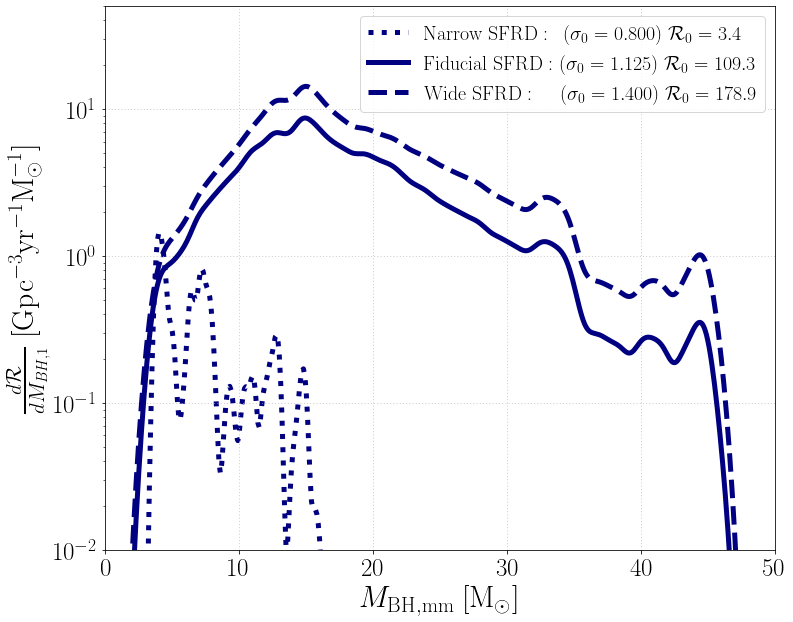

In [8]:
####################################################
plot_mass_distribution(sim_dir = data_dir, x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz-0.05_alpha-1.77_sigma0%s_sigmaz0.05_zBinned'%(x) for x in [0.08, 1.125, 1.4]],
                       show_hist = False, show_KDE = True, kde_width = 0.07, plot_LIGO = False, linestyles = [':','-', '--'], colors = ['navy',  'navy', 'navy'], 
                       bootstrap = False, bootstraps = 50, save_name = 'SFRD_width_variations.pdf', save_plot=True, 
                       xlabel = r'$M_{\mathrm{BH, mm}} \ \rm [M_{\odot}]$', 
                       labels = ['$\mathrm{Narrow \ SFRD: \ } \phantom{0} (\sigma_0 = 0.080) \  \mathcal{R}_{0} = \ $',
                                 '$\mathrm{Fiducial \ SFRD: \ } (\sigma_0 = 1.125) \ \mathcal{R}_{0}= \ $', 
                                 '$\mathrm{Wide \ SFRD: \ } \phantom{xx} (\sigma_0 = 1.400) \  \mathcal{R}_{0} = \ $'])



# Redshift evolution of the width

nplot 0 

rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.025_zBinned
Reading  /n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Flat \ width \ SFRD: \ } (\sigma_z = 0.025) \ \mathcal{R}_{0} = \ $  len(table)= 2252487  Rate =  92.23054132419672  Gpc-3 yr-1
0 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Fiducial \ SFRD: \ } \phantom{xx} (\sigma_z = 0.050) \ \mathcal{R}_{0}= \ $  len(table)= 2252487  Rate =  108.83245800554734  Gpc-3 yr-1
1 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.1_zBinned
Reading  /n/holystor

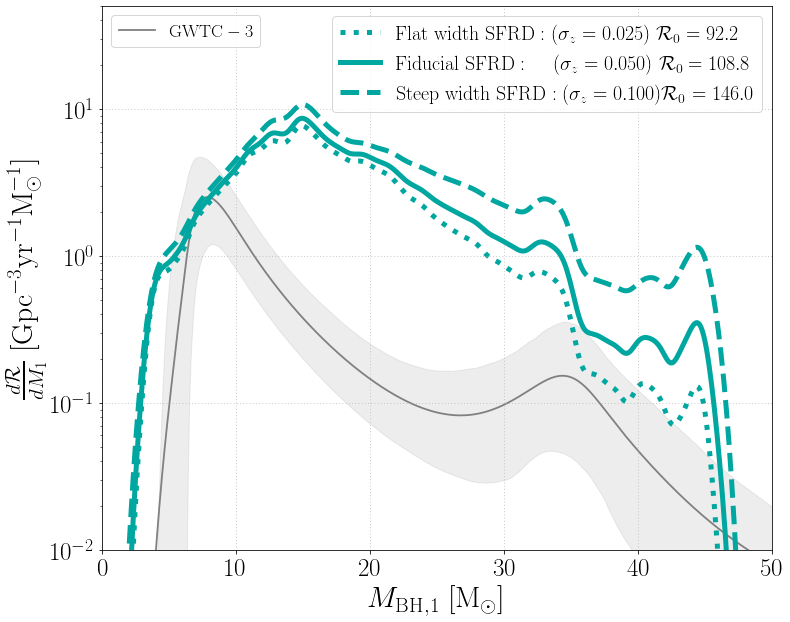

In [21]:
####################################################

plot_mass_distribution(sim_dir = data_dir, x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz%s_zBinned'%(x) for x in [0.025, 0.05, 0.1]],
                       show_hist = False, show_KDE = True, kde_width = 0.07, plot_LIGO = True, linestyles = [':','-', '--'], colors = ['#00a6a0',  '#00a6a0', '#00a6a0'], 
                       bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_width_variations.pdf', save_plot=True, 
                       labels = ['$\mathrm{Flat \ width \ SFRD: \ } \phantom{i} (\sigma_z = 0.025) \ \mathcal{R}_{0} = \ $',
                                 '$\mathrm{Fiducial \ SFRD: \ } \phantom{xxi} (\sigma_z = 0.050) \ \mathcal{R}_{0}= \ $', 
                                 '$\mathrm{Steep \ width \ SFRD: \ } (\sigma_z = 0.100) \\mathcal{R}_{0} = \ $'],
                       )




# Mean metallicity at z=0

nplot 0 

rate_key Rates_mu00.015_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{low \ <Z_0> : \ } \phantom{xxx} (\mu_0 = 0.015) \ \mathcal{R}_{0} = \ $  len(table)= 2252487  Rate =  206.80315998502937  Gpc-3 yr-1
0 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Fiducial \ <Z_0> : \ } (\mu_0 = 0.025) \ \mathcal{R}_{0} = \ $  len(table)= 2252487  Rate =  108.83245800554734  Gpc-3 yr-1
1 3 3
rate_key Rates_mu00.035_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /n/holystore01/LABS

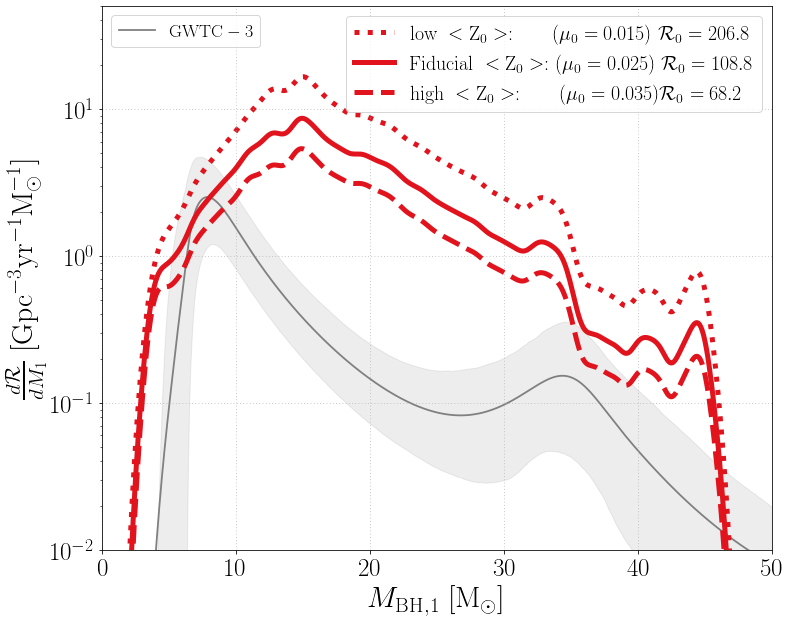

In [22]:
####################################################

plot_mass_distribution(sim_dir = data_dir, x_key = 'M_moreMassive',  rate_keys = ['Rates_mu0%s_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'%(x) for x in [0.015, 0.025, 0.035]],
                       show_hist = False, show_KDE = True, kde_width = 0.07, plot_LIGO = True, linestyles = [':','-', '--'], colors = ['#e1131d',  '#e1131d', '#e1131d'], 
                       bootstrap = False, bootstraps = 50, save_name = 'SFRD_meanZ_variations.pdf', save_plot=True, 
                       labels = ['$\mathrm{low \ <Z_0> : \ } \phantom{xxx} (\mu_0 = 0.015) \ \mathcal{R}_{0} = \ $',
                                 '$\mathrm{Fiducial \ <Z_0> : \ } (\mu_0 = 0.025) \ \mathcal{R}_{0} = \ $', 
                                 '$\mathrm{high \ <Z_0> : \ } \phantom{xxx} (\mu_0 = 0.035) \ \mathcal{R}_{0} = \ $'],
                       )




# Redshift evolution of mean metallicity


nplot 0 

rate_key Rates_mu00.025_muz-0.01_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Flat \ SFRD: \ } \phantom{xx} (\mu_z = -0.01) \ \mathcal{R}_{0} = \ $  len(table)= 2252487  Rate =  93.64520783624933  Gpc-3 yr-1
0 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Fiducial \ SFRD: \ } (\mu_z = -0.05) \ \mathcal{R}_{0}= \ $  len(table)= 2252487  Rate =  108.83245800554734  Gpc-3 yr-1
1 3 3
rate_key Rates_mu00.025_muz-0.25_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /n/holystore01/LABS/hernq

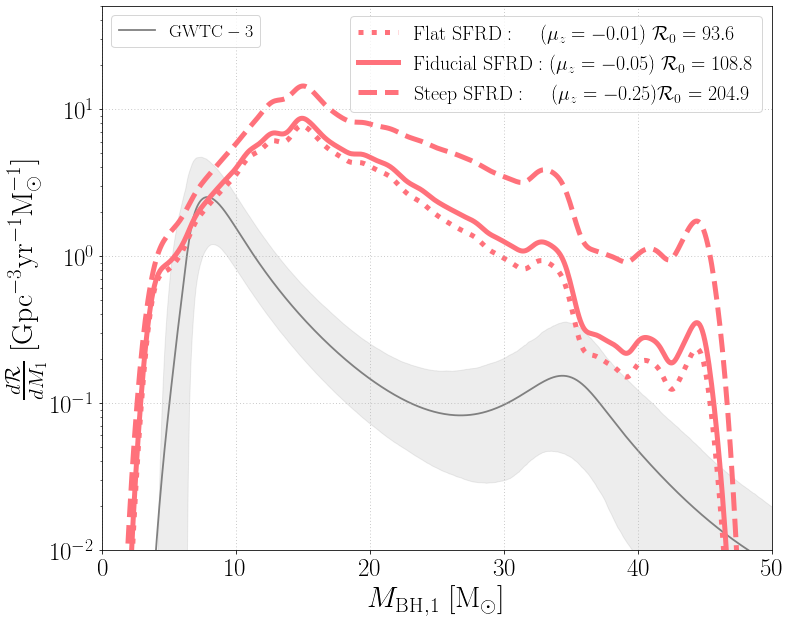

In [23]:
####################################################

plot_mass_distribution(sim_dir = data_dir, x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz%s_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'%(x) for x in [-0.01, -0.05, -0.25]],
                       show_hist = False, show_KDE = True, kde_width = 0.07, plot_LIGO = True, linestyles = [':','-', '--'], colors = ['#ff717b',  '#ff717b', '#ff717b'], 
                       bootstrap = False, bootstraps = 50, save_name = 'SFRD_zevol_mean_variations.pdf', save_plot=True, 
                       labels = ['$\mathrm{Flat \ SFRD: \ } \phantom{xx} (\mu_z = -0.01) \ \mathcal{R}_{0} = \ $',
                                 '$\mathrm{Fiducial \ SFRD: \ } (\mu_z = -0.05) \ \mathcal{R}_{0}= \ $', 
                                 '$\mathrm{Steep \ SFRD: \ } \phantom{xx} (\mu_z = -0.25) \ \mathcal{R}_{0} = \ $'],
                       )




# Skewness


nplot 0 

rate_key Rates_mu00.025_muz-0.05_alpha-0.9_sigma01.125_sigmaz0.05_zBinned
Reading  /n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Symmetric \ SFRD: \ } $$(\alpha = -0.9) $$ \ \mathcal{R}_{0} = \ $  len(table)= 2252487  Rate =  165.86561777165588  Gpc-3 yr-1
0 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Fiducial \ SFRD: \ } $$(\alpha = -1.77) $$\ \mathcal{R}_{0}= \ $  len(table)= 2252487  Rate =  109.33972509651458  Gpc-3 yr-1
1 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-3.5_sigma01.125_sigmaz0.05_zBinned
Reading  /n/holystore01/LABS/hern

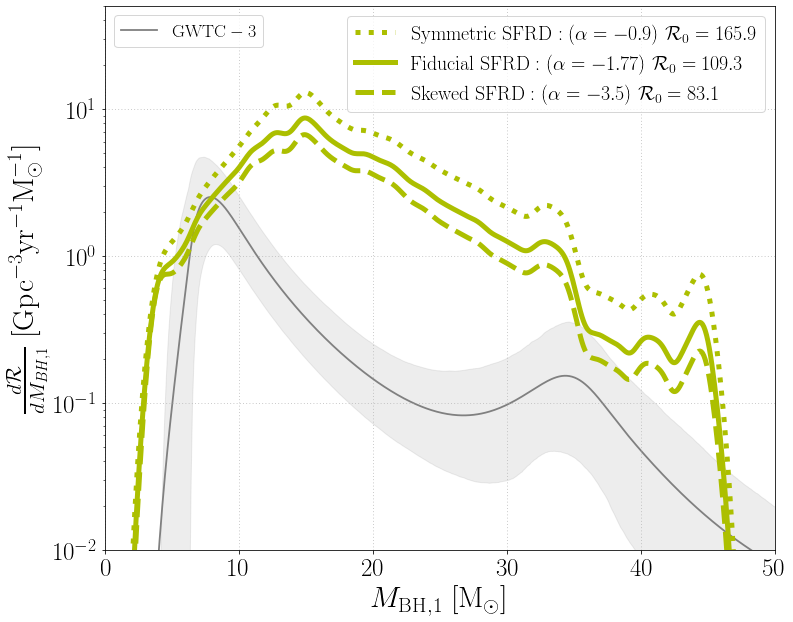

In [10]:
####################################################
plot_mass_distribution(sim_dir = data_dir, x_key = 'M_moreMassive',  rate_keys = ['Rates_mu00.025_muz-0.05_alpha%s_sigma01.125_sigmaz0.05_zBinned'%(x) for x in [-0.9, -1.77, -3.5]],
                       show_hist = False, show_KDE = True, kde_width = 0.07, plot_LIGO = True, linestyles = [':','-', '--'], colors = ['#acbf00',  '#acbf00', '#acbf00'], 
                       bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', save_plot=False, 
                       labels = ['$\mathrm{Symmetric \ SFRD: \ } $'+r'$(\alpha = -0.9) $'+'$ \ \mathcal{R}_{0} = \ $',
                                 '$\mathrm{Fiducial \ SFRD: \ } $'+r'$(\alpha = -1.77) $'+'$\ \mathcal{R}_{0}= \ $', 
                                 '$\mathrm{Skewed \ SFRD: \ }  $'+r'$(\alpha = -3.5) $'+'$\ \mathcal{R}_{0} = \ $'],
                       )




# Normalization of SFRD


nplot 0 

rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.01_b2.6_c3.2_d6.2_zBinned
Reading  /n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Madau \& Fragos 2017: } \ \mathcal{R}_{0} = \ $  len(table)= 2252487  Rate =  93.18837274895172  Gpc-3 yr-1
0 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned
Reading  /n/holystore01/LABS/hernquist_lab/Users/lvanson/CompasOutput/v02.19.04/SFRD_fit_data/fWR1.0coolWind1.0/output//Rate_info.hdf5
sum(DCO_mask) 2255684
np.shape(intrinsic_rate_density) (2255684, 10)
i_per_crude_bin 10.0
$\mathrm{Fiducial: \ } \phantom{xxxxxx} \ \mathcal{R}_{0}= \ $  len(table)= 2252487  Rate =  109.33972509651458  Gpc-3 yr-1
1 3 3
rate_key Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.01_b2.77_c2.9_d4.7_zBinned
Reading  /n/holysto

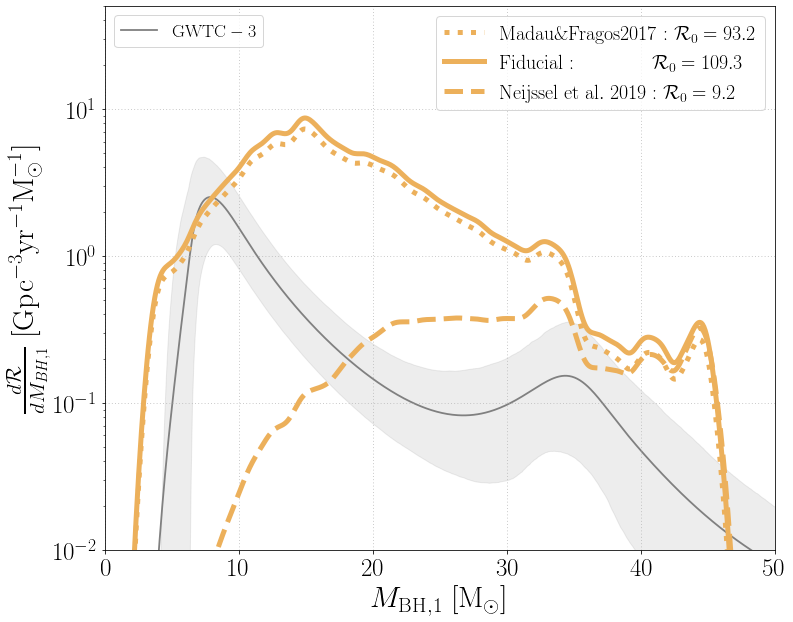

In [9]:
####################################################
plot_mass_distribution(sim_dir = data_dir, x_key = 'M_moreMassive',  
                       rate_keys = ['Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.01_b2.6_c3.2_d6.2_zBinned',
                                    'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned',#_a0.02_b1.45_c4.43_d5.86_zBinned',
                                    'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.01_b2.77_c2.9_d4.7_zBinned'],
                       show_hist = False, show_KDE = True, kde_width = 0.07, plot_LIGO = True, linestyles = [':','-', '--'], colors = ['#ecb05b',  '#ecb05b', '#ecb05b'], 
                       bootstrap = False, bootstraps = 50, save_name = 'SFRD_skewness_variations.pdf', save_plot=True, 
                       labels = ['$\mathrm{Madau \& Fragos 2017: } \ \mathcal{R}_{0} = \ $',
                                 '$\mathrm{Fiducial: \ } \phantom{xxxxxx} \ \mathcal{R}_{0}= \ $', 
                                 '$\mathrm{Neijssel \ et \ al. \ 2019:  }  \ \mathcal{R}_{0} = \ $'],
                       )


